Imports y configuración

In [ ]:
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive

Carga y limpieza del dataset

In [12]:
# Montar Drive
drive.mount('/content/drive')

# Cargar datos
df = pd.read_csv("/content/drive/MyDrive/Deep Learning/Integrador/Segundo Entregable/sentiment_analysis_dataset.csv",
                 delimiter=',',)
df = df[['text', 'emotion']]  # solo columnas necesarias

# Limpiar texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

df["texto_limpio"] = df["text"].apply(clean_text)

# Codificar etiquetas
encoder = LabelEncoder()  #  Crea una instancia de LabelEncoder de scikit-learn, que sirve para convertir clases categóricas a números enteros consecutivos.
df["label_codificada"] = encoder.fit_transform(df["emotion"])  # Transforma la columna emotion (que tiene strings como "thankful", "frustrated", etc.) en una nueva columna con números.
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))#Crea un diccionario (label_mapping) que mapea cada emoción a su número.
print("Etiquetas codificadas:", label_mapping)
# Mostrar cuántas veces aparece cada emoción
print("\nFrecuencia de emociones en el dataset:")
print(df["emotion"].value_counts())

# Mostrar cantidad total de ejemplos
print("\nCantidad total de ejemplos:", len(df))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Etiquetas codificadas: {'confident': np.int64(0), 'daring': np.int64(1), 'distant': np.int64(2), 'embarrassed': np.int64(3), 'frustrated': np.int64(4), 'irritated': np.int64(5), 'isolated': np.int64(6), 'jealous': np.int64(7), 'loving': np.int64(8), 'optimistic': np.int64(9), 'overwhelmed': np.int64(10), 'playful': np.int64(11), 'relaxed': np.int64(12), 'responsive': np.int64(13), 'secure': np.int64(14), 'sleepy': np.int64(15), 'stupid': np.int64(16), 'successful': np.int64(17), 'surprised': np.int64(18), 'thankful': np.int64(19)}

Frecuencia de emociones en el dataset:
emotion
thankful       150
sleepy         150
overwhelmed    140
jealous        140
successful     140
irritated      140
secure         140
confident      140
surprised      140
embarrassed    130
relaxed        130
distant        130
loving         130
playful        130
isolated       120
f

Grafico Cantidad de apariciones por emocion

<ipython-input-13-1114468186>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_emociones.index, y=conteo_emociones.values, palette="pastel")


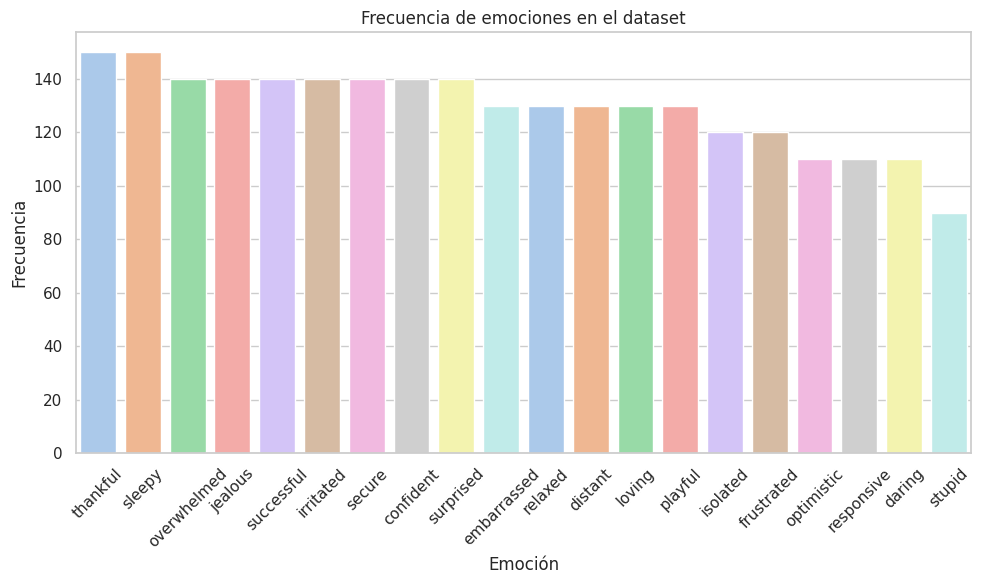

In [13]:

# Configuración del estilo
sns.set(style="whitegrid")

# Contar las emociones
conteo_emociones = df["emotion"].value_counts()

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=conteo_emociones.index, y=conteo_emociones.values, palette="pastel")

# Etiquetas y título
plt.xlabel("Emoción")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de emociones en el dataset")
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar gráfico
plt.show()

Tokenización y Dataset personalizado

In [14]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased") #Este tokenizador se encarga de convertir texto en tokens numéricos

class TweetEmotionDataset(Dataset): # Define el dataset compatible con PyTorch
    def __init__(self, encodings, labels): #Guarda los tokens (input_ids, attention_mask) y las etiquetas codificadas (números del 0 al 20 para cada emoción).
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):  # Permite que puedas acceder a un solo ejemplo (idx) devolviendo: input_ids[idx] attention_mask[idx] label[idx]  Así el modelo puede procesar un batch a la vez fácilmente.
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self): # Informa cuántos elementos hay en el dataset. Es necesario para usar el DataLoader.

        return len(self.labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Separar en entrenamiento y validación

In [15]:
#Usa train_test_split de sklearn para dividir el dataset: 80% entrenamiento (train_texts, train_labels) 20% validación (val_texts, val_labels)  random_state=42 asegura que la división sea siempre igual (reproducible).
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["texto_limpio"].tolist(),
    df["label_codificada"].tolist(),
    test_size=0.2,
    random_state=42
)
# Aplica el tokenizador a los textos:padding=True: agrega ceros si el texto es corto. truncation=True: corta textos que superan los 128 tokens. return_tensors="pt": convierte el resultado a tensores de PyTorch (input_ids, attention_mask).
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
#Crea dos objetos que PyTorch puede usar con DataLoader, uno para entrenamiento y otro para validación.
train_dataset = TweetEmotionDataset(train_encodings, torch.tensor(train_labels))
val_dataset = TweetEmotionDataset(val_encodings, torch.tensor(val_labels))

Modelo

In [16]:
class BertEmotionClassifier(nn.Module): # clase que define nuestra red neuronal. nn.Module es la clase base para todos los modelos en PyTorch
    def __init__(self, num_labels=21): #Constructor del modelo.
        super(BertEmotionClassifier, self).__init__() #Llama al constructor de la clase base (nn.Module) para inicializar bien la arquitectura interna del modelo en PyTorch.
        self.bert = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased") #Aquí cargamos el modelo preentrenado DistilBERT
        self.dropout = nn.Dropout(0.3) #Regularización para evitar overfitting


         # Nueva MLP: dos capas lineales con ReLU
        self.mlp = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),  # Capa oculta
            nn.ReLU(),                                     # Activación no lineal
            nn.Dropout(0.3),                                # Dropout para regularización
            nn.Linear(256, num_labels)                     # Capa de salida
        )

        self.softmax = nn.Softmax(dim=1) #Aplica la función softmax para convertir los valores de salida en porcentajes/probabilidades entre 0 y 1 que suman 1.

    def forward(self, input_ids, attention_mask): #  función de propagación hacia adelante. input_ids: IDs de los tokens del texto. attention_mask: máscara que indica qué tokens son reales y cuáles son padding (1 = real, 0 = padding).
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) #Pasamos los tokens por el modelo DistilBERT.Esto nos devuelve un tensor con todos los embeddings del texto, uno por cada palabra.
        cls_output = outputs.last_hidden_state[:, 0, :] #Extraemos la salida del token especial [CLS], que está en la posición 0.Este token representa el significado global de la oración.[batch_size, seq_len, hidden_size]
        x = self.dropout(cls_output)#Aplicamos la capa de dropout solo al vector [CLS].
        logits = self.mlp(x)#Pasamos ese vector por la capa densa → obtenemos un vector de tamaño 21 (1 valor por emoción).
        probs = self.softmax(logits)#Convertimos esos valores a porcentajes mediante softmax.
        return probs

Entrenamiento

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   #  Detecta si hay GPU disponible. Si sí, usa "cuda" para acelerar; si no, usa CPU.
# Crea los "cargadores" de datos que dividen el dataset en mini-lotes (batch_size).
#shuffle=True hace que el orden cambie en cada época (para evitar sesgos).
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
losses_por_lr = {}  # Diccionario para guardar las pérdidas de cada learning rate
# Bucle para probar varios learning rates
for lr in [5e-5, 3e-5, 2e-5, 1e-5]:
    print(f"\n🔁 Probando con learning rate: {lr}")

    # 1. Crear modelo
    model = BertEmotionClassifier(num_labels=len(encoder.classes_)).to(device)    # Crea una nueva instancia del modelo para cada lr y lo manda al dispositivo

    # 2. Optimizer
    optimizer = AdamW(model.parameters(), lr=lr)# Crea un optimizador AdamW con el lr que se está probando.

    # 3. Pesos de clase balanceados
    class_weights = compute_class_weight(# Calcula pesos para cada clase en función de su frecuencia en el dataset. Así, las clases poco frecuentes reciben más “importancia” en la función de pérdida.
        class_weight='balanced',
        classes=np.unique(df["label_codificada"]),
        y=df["label_codificada"]
    )
    #Crea el tensor con los pesos y lo manda al dispositivo. Luego define la función de pérdida (criterion) con esos pesos incluidos.
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # 4. Entrenamiento por pocas épocas Entrenará el modelo por 20 épocas para cada lr. best_loss guarda la mejor pérdida registrada para ese lr
    EPOCHS = 25
    best_loss = float("inf")

    losses_por_lr[lr] = []  # Lista para guardar la pérdida de cada época con este learning rate

    for epoch in range(EPOCHS):#Bucle para recorrer todas las épocas.
        model.train() #pone el modelo en modo entrenamiento.
        total_loss = 0 #guarda la suma de la pérdida en la época.

        for batch in train_loader: #Recorre los datos de entrenamiento por mini-lotes.
            optimizer.zero_grad() # Limpia los gradientes acumulados antes de calcular nuevos.
            #Extrae el lote de datos y lo manda al dispositivo
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device) #Etiquetas veraderas

            outputs = model(input_ids, attention_mask) # usamos el metodo fordward de la clase BertEmotionClassifier (obtememos lo q predice el modelo)
            # Calcula la pérdida, retropropaga los errores y ajusta los pesos con optimizer.step().
            loss = criterion(outputs, labels)
            loss.backward() #Calculamos los gradientes
            optimizer.step() #actualizamos los pesos del modelo usando los gradientes calculados.
            total_loss += loss.item() #Suma la pérdida del batch para calcular el promedio al final de la época.

        epoch_loss = total_loss / len(train_loader) # Calcula la pérdida promedio de la época y la imprime para seguimiento.
        losses_por_lr[lr].append(epoch_loss)  # Guarda la pérdida de esta época
        print(f"📘 LR={lr} | Época {epoch+1}/{EPOCHS} - Pérdida: {epoch_loss:.4f}")

        # Guardar el mejor modelo por learning rate
        if epoch_loss < best_loss: #Si esta época obtuvo la mejor pérdida de entrenamiento para ese lr, se guarda el modelo con ese valor.
            best_loss = epoch_loss
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Deep Learning/Integrador/3)Tercer Entregable/modelosBertRedMLP/modelo_lr_{lr}.pt")
            print(f"✔ Modelo guardado para LR={lr} con pérdida: {epoch_loss:.4f}")


🔁 Probando con learning rate: 5e-05
📘 LR=5e-05 | Época 1/25 - Pérdida: 2.9957
✔ Modelo guardado para LR=5e-05 con pérdida: 2.9957
📘 LR=5e-05 | Época 2/25 - Pérdida: 2.9951
✔ Modelo guardado para LR=5e-05 con pérdida: 2.9951
📘 LR=5e-05 | Época 3/25 - Pérdida: 2.9869
✔ Modelo guardado para LR=5e-05 con pérdida: 2.9869
📘 LR=5e-05 | Época 4/25 - Pérdida: 2.9741
✔ Modelo guardado para LR=5e-05 con pérdida: 2.9741
📘 LR=5e-05 | Época 5/25 - Pérdida: 2.9379
✔ Modelo guardado para LR=5e-05 con pérdida: 2.9379
📘 LR=5e-05 | Época 6/25 - Pérdida: 2.9136
✔ Modelo guardado para LR=5e-05 con pérdida: 2.9136
📘 LR=5e-05 | Época 7/25 - Pérdida: 2.8972
✔ Modelo guardado para LR=5e-05 con pérdida: 2.8972
📘 LR=5e-05 | Época 8/25 - Pérdida: 2.8814
✔ Modelo guardado para LR=5e-05 con pérdida: 2.8814
📘 LR=5e-05 | Época 9/25 - Pérdida: 2.8848
📘 LR=5e-05 | Época 10/25 - Pérdida: 2.8582
✔ Modelo guardado para LR=5e-05 con pérdida: 2.8582
📘 LR=5e-05 | Época 11/25 - Pérdida: 2.8749
📘 LR=5e-05 | Época 12/25 - Pérd

Grafico de perdidas

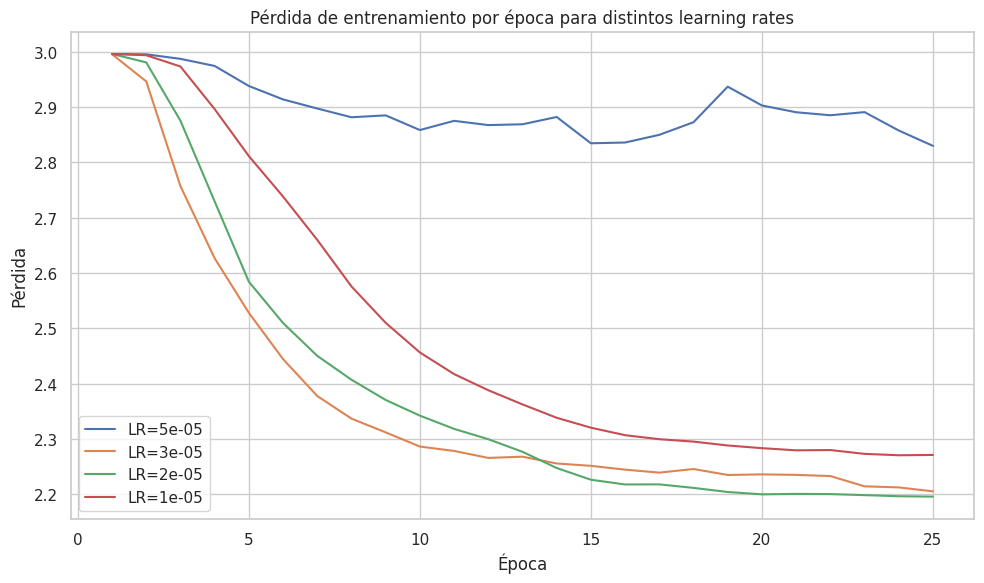

In [19]:
# Gráfico de pérdidas por learning rate
plt.figure(figsize=(10, 6))
for lr, losses in losses_por_lr.items():
    plt.plot(range(1, EPOCHS + 1), losses, label=f"LR={lr}")

plt.title("Pérdida de entrenamiento por época para distintos learning rates")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluación

In [20]:
# Diccionarios para almacenar métricas
accuracies = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}
support_dict = {}

for lr in [5e-5, 3e-5, 2e-5, 1e-5]:
    print(f"\n📊 Evaluando modelo entrenado con learning rate: {lr}")

    # 1. Cargar el modelo entrenado
    model = BertEmotionClassifier(num_labels=len(encoder.classes_)).to(device) #Crea una nueva instancia del modelo y la manda a CPU o GPU, según el dispositivo disponible.

    #Carga los pesos entrenados del modelo correspondiente a ese lr, y lo pone en modo evaluación (eval() desactiva el dropout y el cálculo de gradientes).
    model.load_state_dict(torch.load(f"/content/drive/MyDrive/Deep Learning/Integrador/3)Tercer Entregable/modelosBertRedMLP/modelo_lr_{lr}.pt"))
    model.eval()

    # Inicializa listas para almacenar todas las predicciones del modelo y las etiquetas reales. Se usarán para calcular métricas al final.
    all_preds = []
    all_labels = []

    with torch.no_grad(): #Desactiva el cálculo de gradientes durante la evaluación, lo cual ahorra memoria y hace el proceso más rápido.
        for batch in val_loader: # Itera sobre el set de validación por mini-lotes (batches).
            #Extrae los datos de entrada del batch y los manda al dispositivo
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            probs = model(input_ids, attention_mask) #Genera las probabilidades de cada emoción usando el modelo cargado.
            preds = torch.argmax(probs, dim=1) # Toma la emoción más probable (la que tiene el mayor valor) como predicción final.
            #Agrega las predicciones y las etiquetas reales a sus listas respectivas. Se convierten a NumPy y CPU para procesarlas fácilmente después.
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 3. Imprimir métricas
    acc = accuracy_score(all_labels, all_preds)#Calcula el accuracy global, es decir, el porcentaje de predicciones correctas.
    accuracies[lr] = acc  # Guardmos el resultado para luego graficar
    report = classification_report(all_labels, all_preds, target_names=encoder.classes_, output_dict=True)
     # Extraemos métricas promedio ponderadas por clase
    precision_dict[lr] = report['weighted avg']['precision']
    recall_dict[lr] = report['weighted avg']['recall']
    f1_dict[lr] = report['weighted avg']['f1-score']
    support_dict[lr] = report['weighted avg']['support']  # puede ser útil para ver balance

    print(f"🔹 Accuracy: {acc:.4f}")
    print("🔹 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=encoder.classes_))


📊 Evaluando modelo entrenado con learning rate: 5e-05


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

🔹 Accuracy: 0.1332
🔹 Classification Report:
              precision    recall  f1-score   support

   confident       0.06      0.95      0.12        22
      daring       0.00      0.00      0.00        18
     distant       0.00      0.00      0.00        21
 embarrassed       0.00      0.00      0.00        34
  frustrated       0.00      0.00      0.00        24
   irritated       0.00      0.00      0.00        39
    isolated       0.20      0.35      0.26        17
     jealous       0.14      0.23      0.17        22
      loving       0.13      0.44      0.20        18
  optimistic       0.00      0.00      0.00        22
 overwhelmed       0.24      0.27      0.26        22
     playful       0.00      0.00      0.00        21
     relaxed       0.00      0.00      0.00        31
  responsive       0.00      0.00      0.00        26
      secure       0.00      0.00      0.00        31
      sleepy       0.00      0.00      0.00        31
      stupid       0.00      0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Graficos

In [21]:
import matplotlib.ticker as ticker
import matplotlib.ticker as ticker

def frange(start, stop, step):
    while start <= stop:
        yield round(start, 4)
        start += step

def plot_metric(metric_dict, title, ylabel, ytick_step=None):
    plt.figure(figsize=(8, 5))
    values = list(metric_dict.values())
    bars = plt.bar(lrs, values, color='mediumseagreen')

    plt.title(title)
    plt.xlabel("Learning Rate")
    plt.ylabel(ylabel)

    ax = plt.gca()

    if ylabel.lower() != 'support':
        step = ytick_step if ytick_step else 0.05  # Aumentar a 0.05 o más
        yticks = list(frange(0, 1.01, step))
        plt.ylim(0, max(yticks))
        plt.yticks(yticks, fontsize=10)
    else:
        max_support = max(values)
        step = ytick_step if ytick_step else 20
        plt.ylim(0, max_support + step)
        plt.yticks(range(0, int(max_support + step), step), fontsize=10)

    # 🔹 Mostrar valores encima de cada barra
    for bar, val in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{val:.3f}",
                 ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con salto de 0.02 para métricas y 10 para soporte
plot_metric(accuracies, "Accuracy por Learning Rate", "Accuracy", ytick_step=0.05)
plot_metric(precision_dict, "Precision (ponderada) por Learning Rate", "Precision", ytick_step=0.05)
plot_metric(recall_dict, "Recall (ponderado) por Learning Rate", "Recall", ytick_step=0.05)
plot_metric(f1_dict, "F1-Score (ponderado) por Learning Rate", "F1-Score", ytick_step=0.05)
plot_metric(support_dict, "Support (ponderado) por Learning Rate", "Support", ytick_step=20)

NameError: name 'lrs' is not defined

<Figure size 800x500 with 0 Axes>

Diccionario de traduccion


In [ ]:
translation = {
    'joyful': 'Felicidad',
    'daring': 'Atrevimiento',
    'optimistic': 'Optimista',
    'playful': 'Juguetón',
    'powerful': 'Empoderado',
    'surprised': 'Sorpresa',
    'successful': 'Triunfo',
    'confident': 'Confiado',
    'peaceful': 'Paz',
    'secure': 'Seguro',
    'thankful': 'Agradecido',
    'loving': 'Enamorado',
    'relaxed': 'Relajado',
    'responsive': 'Responsable',
    'sad': 'Tristeza',
    'sleepy': 'Adormilado',
    'isolated': 'Aislado',
    'stupid': 'Tonto',
    'mad': 'Furia',
    'distant': 'Distante',
    'frustrated': 'Frustrado',
    'irritated': 'Irritado',
    'jealous': 'Celoso',
    'scared': 'Miedo',
    'embarrassed': 'Apenado',
    'overwhelmed': 'Preocupado',
}

Predicción de sentimientos por oración

In [ ]:
def mostrar_sentimientos(oracion, lr):

    lr_str = f"{lr:.0e}"  # convierte 2e-05 a '2e-05'
    # Cargamos el modelo específico entrenado con lr=5e-5, que fue el de mayor precision
    model = BertEmotionClassifier(num_labels=len(encoder.classes_)).to(device)
    model.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Integrador/3)Tercer Entregable/modelosBertRedMLP/modelo_lr_2e-05.pt"))
    model.eval()  # Lo ponemos en modo evaluación

    tokens = tokenizer(oracion, return_tensors="pt", padding=True, truncation=True, max_length=128) #Usamos el tokenizer para convertir el texto a tokens numéricos que BERT pueda entender, return_tensors="pt" hace que el resultado sea un diccionario de tensores de PyTorch.
    tokens = {k: v.to(device) for k, v in tokens.items()} # Enviamos cada tensor (por ejemplo, input_ids, attention_mask) al mismo dispositivo que el modelo

    with torch.no_grad():# Desactivamos el cálculo de gradientes para este bloque de código, porque: No vamos a entrenar el modelo
        probs = model(**tokens)[0] # Pasamos los tokens por el modelo. El modelo devuelve un tensor con 21 valores (uno por emoción), y ya aplicó softmax, así que esos valores suman 1., [0] accede al único resultado del batch (como solo pasamos una oración).

    # Creamos un diccionario donde: La clave es el nombre de la emoción (encoder.classes_[i]) y El valor es el porcentaje estimado (probabilidad * 100)
    porcentajes = {
        translation.get(encoder.classes_[i], encoder.classes_[i]): float(probs[i] * 100)
        for i in range(len(probs))
    }

    # Ordenamos el diccionario de mayor a menor porcentaje.
    return dict(sorted(porcentajes.items(), key=lambda x: -x[1]))

resultado = mostrar_sentimientos("que bien que la pase ayer en mi cumpleaños",lr=2e-05)

# Imprimimos cada emoción con su porcentaje
for emocion, porcentaje in resultado.items():
    print(f"{emocion}: {porcentaje:.2f}%")


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

Ver resultados graficamente

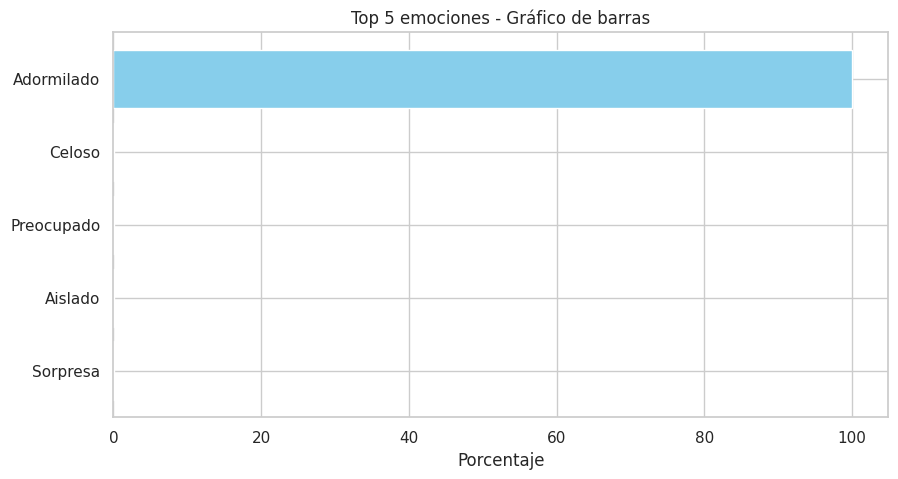

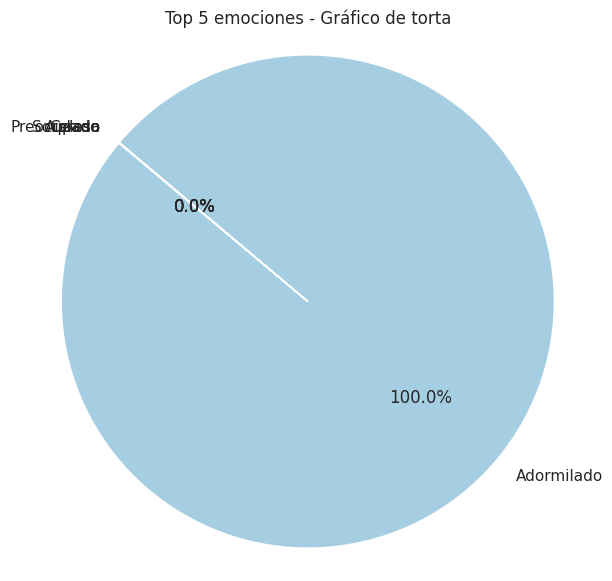

In [ ]:
import matplotlib.pyplot as plt

# Usamos los primeros N sentimientos con mayor porcentaje
N = 5
emociones = list(resultado.keys())[:N]
porcentajes = list(resultado.values())[:N]

# Gráfico de barras horizontales
plt.figure(figsize=(10, 5))
plt.barh(emociones, porcentajes, color='skyblue')
plt.xlabel("Porcentaje")
plt.title("Top 5 emociones - Gráfico de barras")
plt.gca().invert_yaxis()  # Muestra el valor más alto arriba
plt.show()

# Gráfico de torta (pie chart)
plt.figure(figsize=(7, 7))
plt.pie(porcentajes, labels=emociones, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Top 5 emociones - Gráfico de torta")
plt.axis('equal')  # Mantiene la forma circular
plt.show()

In [ ]:
import os
from datetime import datetime

# Lista solo los .pt
modelos = [f for f in os.listdir() if f.endswith(".pt")]

# Mostrar modelos con su fecha de modificación
for modelo in modelos:
    mod_time = os.path.getmtime(modelo)
    readable_time = datetime.fromtimestamp(mod_time).strftime('%Y-%m-%d %H:%M:%S')
    print(f"{modelo} → Guardado el: {readable_time}")